## Assignment 3

### Image mosaic

#### On grading

The homework is graded on a scale of 0 to 100, and each question has a specified number of points. If your answer is not entirely correct, but shows that you are on the right track, we may award partial credit. Overall, you need to acquire at least *45 points* to pass. Otherwise, it is considered as a fail.

In [2]:
%matplotlib inline
from skimage import io, color, transform, img_as_ubyte
from skimage.io import imshow
import skimage
import numpy as np
import matplotlib.pyplot as plt

# Make figures larger
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In this assignment, you will create your own photographic mosaic. A photographic mosaic is an image made up of tiny but complete images that replace the pixels or small patches of another base image. In simpler terms, the image comprises other images. It's a charming and meta concept that has gained immense popularity on the internet. People have, for instance, created an image of a character from [Harry Potter](http://orig04.deviantart.net/d3f5/f/2010/320/7/4/deathy_hallows_snape___mosaic_by_smallrinilady-d330420.jpg) made out of frames from the movies. 

Let's first clarify the terms we will be using in this assignment. The main image that serves as the base of the design is called the *background image*. For instance, in the example given above, the background image would be that of Severus Snape. The smaller images that are used to create the background image are called *replacement images* as they replace the different parts of the background image. In our example, the frames of the movies would be the replacement images. 

The creation of the mosaic is split into two tasks:

1. **Make tiles**. Divide the background image into tiles. You can think of each tile as a separate, smaller image.
2. **Image similarity search**. For each tile, find the most similar image from the collection of replacement images and substitute the tile.

## Make tiles

### Ex. 1.1: Reading the file and shaping the image (20 points)

Begin by reading in the background image from the file `kangaroo.jpg` and store a reference in a variable called `bg_image`. As you have probably guessed it is not Harry Potter.

<img src="kangaroo.jpg" /> 

Our tiles will be $32 \times 32$ pixels. This turns out to be a convenient choice, because our pool of replacement images are also $32 \times 32$ pixels, and therefore no resizing will be necessary.

Here are some clearer instructions to read in the background image from the file `kangaroo.jpg` and store it in a variable named `bg_image`:

1. Load the `kangaroo.jpg` file as the background image using an appropriate function from `skimage`.
2. Convert the integer representation of the image to a float representation using an appropriate function provided by the `skimage` library. This step ensures that the color values are in the range of [0, 1].
3. Rescale the image to $120\%$ of its original size using an appropriate function. 
4. Adjust the shape of `bg_image` to fit exactly a whole number of tiles, which are 32 by 32 pixels each. Here, you should discard any excess rows and columns without scaling the image. From now on, we work on this adjusted image whose number of rows and columns are divisible by $32$. 

Original image size: (580, 790, 3)
Rescaled image size: (696, 948, 3)
Cropped image size: (672, 928, 3)


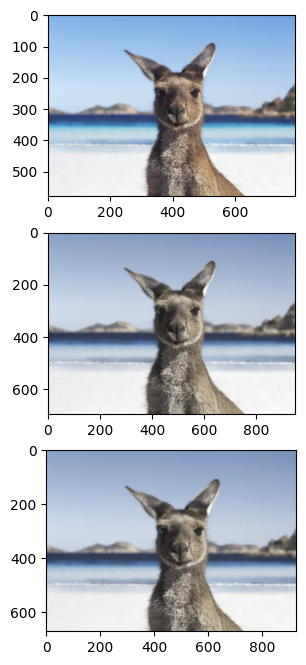

In [4]:
from skimage import io, transform, img_as_float
import matplotlib.pyplot as plt

bg_image = io.imread("kangaroo.jpg")

fig, axs = plt.subplots(3, figsize=(10, 8))  
axs[0].imshow(bg_image)
axs[0].axis('on')  
print(f"Original image size: {bg_image.shape}")

bg_image_float = img_as_float(bg_image)

bg_image_rescaled = transform.rescale(bg_image_float, scale=1.2)

if bg_image_rescaled.shape[2] != 3:
    bg_image_rescaled = bg_image_rescaled[:, :, :3]

axs[1].imshow(bg_image_rescaled)
axs[1].axis('on') 
print(f"Rescaled image size: {bg_image_rescaled.shape}")

tile_size = 32
rows, cols, _ = bg_image_rescaled.shape
new_rows = (rows // tile_size) * tile_size  
new_cols = (cols // tile_size) * tile_size  
bg_image_rescaled_cropped = bg_image_rescaled[:new_rows, :new_cols]  

axs[2].imshow(bg_image_rescaled_cropped)
axs[2].axis('on')  
print(f"Cropped image size: {bg_image_rescaled_cropped.shape}")

plt.show()

### Ex. 1.2: Tile coordinates (24 points)

When arranging tiles, we place them in rows and columns, similar to pixels. This allows us to identify the pixels that a tile at a specific row and column spans. 

The following code requires the completion of the `tile_coordinates` function. This function should return two separate 1-dimensional arrays - the first providing the row coordinates of the given tile, and the second providing the column coordinates.

These arrays are then used to index the pixels of the background image as shown here:

```
    ii, jj = tile_coordinates(i, j, tile_size) # it returns the row and column indices spanning the tile at position (i,j)
    tile = bg_image[ii, jj] # Indexing the pixel of the tile (i,j)   
```

In order to prove the effectiveness of the process, you can utilize `tile_coordinates` function to generate a new image with lower resolution. In this image, every tile of the background image will be replaced with the *mean color* of that tile. Although the new image will have the same number of pixels as the background image, it will have a much lower resolution appearance, because each tile has a uniform color.

Complete the function `low_resolution` and test it with the `bg_image` and different tile sizes (`tile_size`).

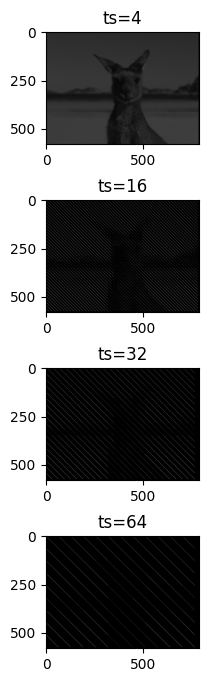

In [6]:
def tile_coordinates(i, j, tile_size):
    row_start = i*tile_size
    row_end = (i+1)*tile_size
    col_start = j*tile_size
    col_end = (j+1)*tile_size

    ii = np.arange(row_start, row_end)
    jj = np.arange(col_start, col_end)

    return ii, jj
    
def low_resolution(img, tile_size):

    rows, cols, _ = bg_image.shape
    
    low_res = np.zeros_like(img)

    for i in range(rows // tile_size):
        for j in range(cols // tile_size ):
           ii, jj = tile_coordinates(i, j, tile_size) 

           tile = bg_image[ii, jj]

           mean_color = np.mean(tile, axis=(0, 1))

           low_res[ii, jj] = mean_color
    
    return low_res

fig, ax = plt.subplots(4)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i,ts in enumerate([4,16,32,64]):
    ax[i].imshow(low_resolution(bg_image,ts))
    ax[i].set_title(f"ts={ts}")
    ax[i].set_xticks([0, 500])
    ax[i].set_yticks([0, 250, 500])

plt.show()

## Image similarity search

After finishing the previous assignment, you have all the necessary components to create a photographic mosaic. The next step is to select images from a pool of replacements most similar to the tiles they are replacing.

To begin, you need to load the set of replacement images.

### Ex. 1.3: Load the replacement images (10 points)

To access the CIFAR-10 dataset, navigate to the dataset homepage <a href=http://www.cs.toronto.edu/~kriz/cifar.html>here</a>. Once there, locate and click the download link specifically for the Python version of the dataset. Verify that you have selected the correct edition before proceeding with the download. The download will result in a compressed file named `cifar-10-python.tar.gz`. Store this file in the same directory as your notebook file. Use your preferred file extraction tool to decompress the file. Once decompressed, the directory containing your notebook should now display a new subdirectory named `cifar-10-batches-py`, which contains the dataset's contents.

In the `cifar` module, we have included a `load_cifar10` function. You can use this function to load image data from a file. It accepts a filename as a parameter and returns a 4-dimensional `numpy` array that contains the image data. Additionally, it also returns a 1-dimensional array that holds the labels for each image. These labels indicate the category of the image. While the labels are not mandatory for this assignment, you can use them to filter images based on your preferences. For example, you can use them to work with images of a particular category, like kittens.

You can use the images from only one batch, for example, `data_batch_1`, but feel free.

In [8]:
from cifar import load_cifar10
replacements, replacement_labels = load_cifar10("cifar-10-batches-py/data_batch_1")


Display a random image from the collection. Your code should display a new random image each time the cell is executed.

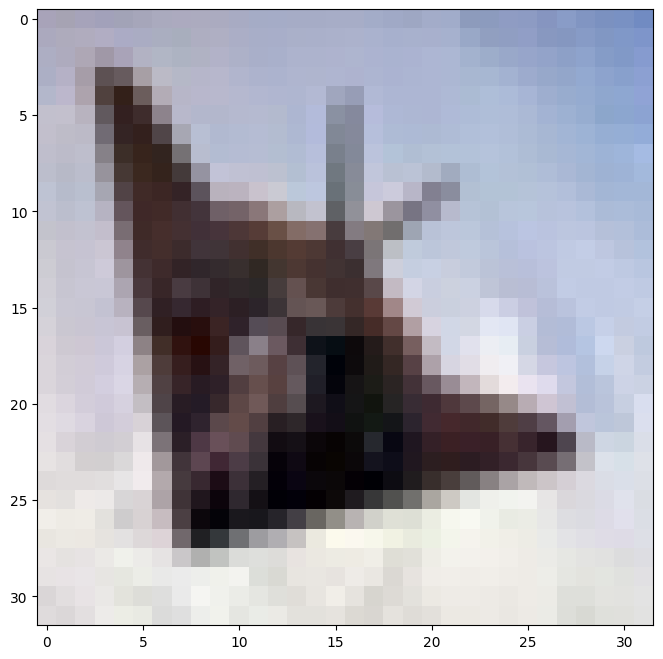

In [11]:
import random

random_index = random.choice(range(len(replacements)))
random_image = replacements[random_index]

image_plot = plt.imshow(random_image)

print(repr(image_plot))

plt.show()

### Image search

Let's focus on a single tile to understand how to find a similar replacement image. The process is the same for all the tiles. The basic idea is to represent both the tile and possible replacement images as vectors and measure the distance between them. If the distance between a tile and a replacement image is low, it means that they are similar, and the replacement image is a good candidate. The best candidate is the one that minimizes the distance.

One way to approach finding replacement images is to think of it as an image search engine. You provide a query image and an image collection, and in return, you get a ranked list of the most similar images from the collection. We have provided two functions that implement parts of this process. The `image_distance_query` function calculates the distance between query images and all images in a collection, and the `plot_best_matches` function visualizes the query images with the top k matches.

However, there is one crucial ingredient missing, and the quality of image retrieval depends entirely on it. We need a function that can convert raw images into vectors that can be compared. Below, we will ask you to write several versions of this function. Please note that you should not have to change anything in the cell following this text.

In [14]:
from scipy.spatial.distance import cdist

def image_distance_query(query_images, collection_images, to_vector_fn, p=2):
    query_vecs = [to_vector_fn(image).reshape(1, -1) for image in query_images]
    query_vecs = np.concatenate(query_vecs)

    collection_vecs = [to_vector_fn(image).reshape(1, -1) for image in collection_images]
    collection_vecs = np.concatenate(collection_vecs)

    return cdist(query_vecs, collection_vecs, 'minkowski', p=p)

def plot_best_matches(distances, query_images, collection_images, top_k=5):
    fig, axes = plt.subplots(nrows=distances.shape[0], ncols=top_k+1, squeeze=False,
                             figsize=(top_k*2, distances.shape[0]*2))

    for i in range(distances.shape[0]):
        top_indices = distances[i].argsort().ravel()
        for j in range(top_k):
            ax = axes[i, j+1]
            ax.axis('off')
            plt.sca(ax)
            top_index = top_indices[j]
            imshow(collection_images[top_index])
            ax.set_title("Top " + str(j + 1) + " match")
        
        ax = axes[i, 0]
        ax.set_title("Query image")
        ax.axis('off')
        plt.sca(ax)
        imshow(query_images[i])


### Ex 1.4: Average color vector (20 points)

The `image_distance_query` function needs a function argument called `to_vector_fn` that converts a 2-dimensional image to a 1-dimensional array or vector. Note that the size of the resulting vector is independent of the input image size. The quality of image retrieval depends on how you define this function. 

To start with, we need to complete the implementation of the `average_color` function, which returns the mean RGB color across all pixels. It means that the vector representation of an input image is an array of size tree corresponding to the mean values for red, green, and blue over all pixels. 

To calculate distances and visualize the results, you can use the `image_distance_query` and `plot_best_matches` functions. Choose 5 images from the replacement pool as query images and use a subset of the replacement images (e.g. 1000) while developing your code. However, make sure to switch to the full set before submitting your work.

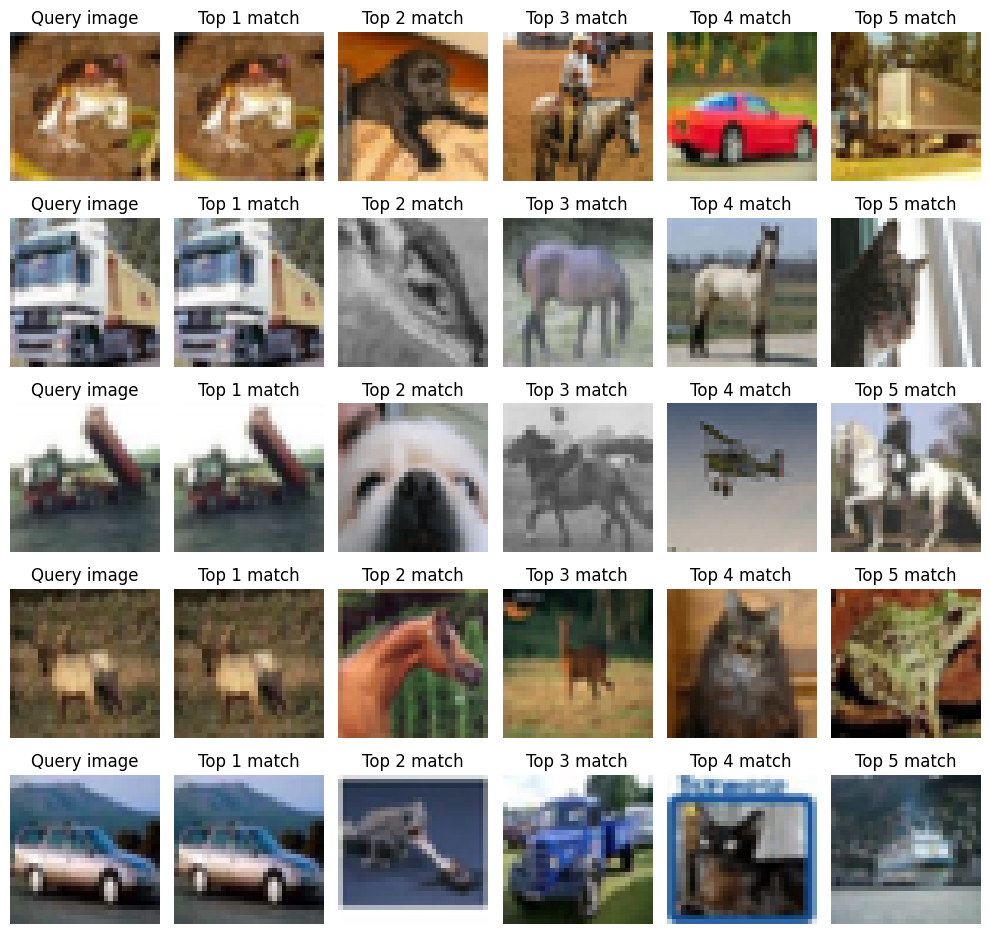

In [17]:
def average_color(image_rgb):
    # Your code here
    mean_red = np.mean(image_rgb[:, :, 0])  
    mean_green = np.mean(image_rgb[:, :, 1])  
    mean_blue = np.mean(image_rgb[:, :, 2])
    
    return np.array([mean_red, mean_green, mean_blue])

subset_images = replacements[:1000]

query_images = replacements[:5]

distances = image_distance_query(query_images, subset_images, average_color)

plot_best_matches(distances, query_images, subset_images, top_k=5)

plt.show() 

### (OPT) Ex 1.5: 8 by 8 grayscale

Create a new function that first reduces the images to grayscale, then resizes the $32 \times 32$ input image to an $8 \times 8$ image by taking the mean pixel intensity in all $4 \times 4$ squares. (You can check if there is a function in `skimage` that does this). Finally flatten the image to one dimension before returning.

Calculate distances and visualize as before.

### (OPT) Ex 1.6: Hue histogram

Create a function that converts an image to the HSV color space using `color.rgb2hsv`. The function should then create a histogram on the hue (first) channel. It's important to note that the edges of the bins should be fixed to ensure that they are comparable across different images.

Once the histogram is created, calculate the distances and visualize them as you have done before.

In [24]:
# Your code here
def hsv(image):
    hsv_image = color.rgb2hsv(image)

    # Your code here

    return hist

# Your code here

### (OPT) Ex 1.7: Joint hue and saturation histogram

Extend the function from the previous assigment to create a joint histogram over the hue and saturation channels. As before the bins should be fixed. Use the function `np.histogram2d` to create the histograms.

In [26]:
# Your code here
def extended_hsv(image):
    hsv_image = color.rgb2hsv(image)

    # Your code here
    return hist

# Your code here

### (OPT) Ex 1.8: Any other strategy you might think of

Here is a chance to be creative. Mixing strategies is also a possiblity.

In [28]:
# Your code here (possibly)

### Ex 1.9: Render photographic mosaic (26 points)

Take the best image-to-vector function from above and use it together with `image_distance_query` to build your image mosaic. You may reuse some of the code you wrote in the `low_resolution` function. 

For computational efficiency you should make sure to only call `image_distance_query` once, and not inside of the loop!

OPTIONAL: As an optional exercise, write your code in a way that it can process different values for `tile_size`. 

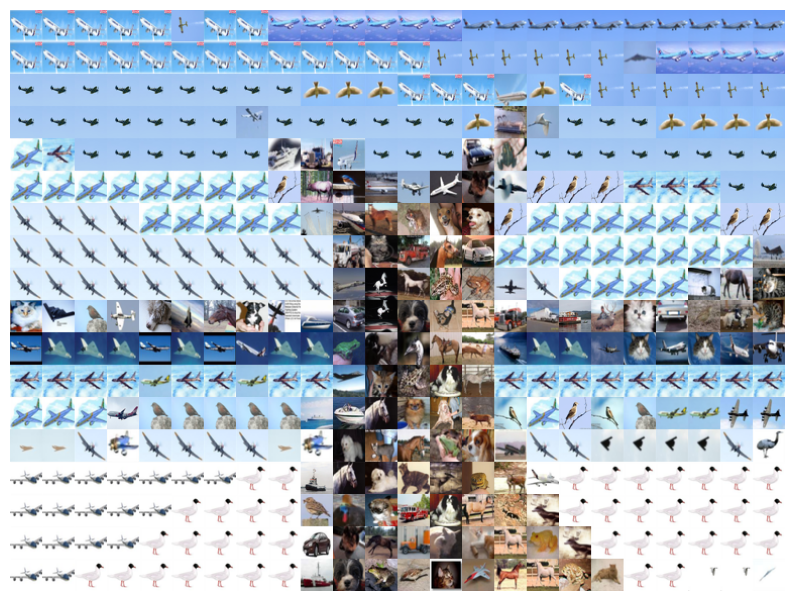

In [25]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

def average_color(image):
    return np.mean(image, axis=(0, 1))

def image_distance_query(target_images, replacement_images):
    distances = []
    for target_image in target_images:
        target_avg_color = average_color(target_image)
        distances_to_replacements = [np.linalg.norm(target_avg_color - average_color(replacement)) for replacement in replacement_images]
        distances.append(distances_to_replacements)
    return distances

def generate_mosaic(target_image_path, replacement_images, tile_size=(32, 32)):
    target_image = imread(target_image_path)
    target_height, target_width = target_image.shape[:2]
    
    num_tiles_y = target_height // tile_size[1]
    num_tiles_x = target_width // tile_size[0]

    target_image_resized = resize(target_image, (num_tiles_y * tile_size[1], num_tiles_x * tile_size[0]))

    target_parts = []
    for y in range(num_tiles_y):
        for x in range(num_tiles_x):
            tile = target_image_resized[y * tile_size[1]: (y + 1) * tile_size[1], x * tile_size[0]: (x + 1) * tile_size[0]]
            target_parts.append(tile)

    matches = image_distance_query(target_parts, replacement_images)

    mosaic = np.zeros_like(target_image_resized)
    for i, (y, x) in enumerate([(y, x) for y in range(num_tiles_y) for x in range(num_tiles_x)]):
        match_queue = np.array(matches[i]).argsort() 
        match_idx = match_queue[0]

        match_img = resize(replacement_images[match_idx], tile_size)
        mosaic[y * tile_size[1]: (y + 1) * tile_size[1], x * tile_size[0]: (x + 1) * tile_size[0]] = match_img
    
    return mosaic

target_image = 'kangaroo.jpg'  
replacements, replacement_labels = load_cifar10("cifar-10-batches-py/data_batch_1")
mosaic = generate_mosaic(target_image, replacements, tile_size=(32, 32))

plt.figure(figsize=(10, 8))
plt.imshow(mosaic)
plt.axis('off')
plt.show()


### Image collections

Here is a small list of free image sources in case you would like to use other (or larger) images for your mosaic.

- [CIFAR-10](http://www.vision.ee.ethz.ch/datasets_extra/pec/). The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. 
- [Food-101](http://www.vision.ee.ethz.ch/datasets_extra/food-101/). We introduce a challenging data set of 101 food categories, with 101,000 images. All images were rescaled to have a maximum side length of 512 pixels.
- [MIRFLICKR-25000](http://press.liacs.nl/mirflickr/mirdownload.html). 25,000 images from Flickr. 